In [161]:
import pandas as pd
import numpy as np
np.random.seed(42)

import math
import json
import seaborn as sns; sns.set()
sns.set_style('white')

from datetime import datetime, timedelta
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, precision_recall_curve, classification_report, roc_auc_score

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [162]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# 1. EDA And Data Cleaning

In this notebook, we will try to predict whether someone will respond to a particular offer, given the offer terms and conditions and the demographic characteristics of the person.

## 1.1 Portfolio

In [163]:
display(portfolio.head())

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


We will transform the channels column by performing a one-hot encoding on the channel types.

In [164]:
portfolio['channels'] = portfolio['channels'].apply(lambda x: np.array(x))

# Transform the channels
for channel in ['email','web','mobile','social']:
    portfolio['is_{}'.format(channel)] = portfolio['channels'].apply(lambda x: channel in x)
    portfolio['is_{}'.format(channel)] = np.where(portfolio['is_{}'.format(channel)], 1, 0)
portfolio = portfolio.drop(['channels'], axis=1)

In [165]:
# Rename id column to offer_id to standardize across different tables
portfolio = portfolio.rename(columns={
    'id' : 'offer_id'
})

display(portfolio.head())

,difficulty,duration,offer_id,offer_type,reward,is_email,is_web,is_mobile,is_social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0


## 1.2 Profile

In [166]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


A quick glance on the data shows several anomalies: 

1. Age column seems to have multiple occurences of the value `118` - Initial hypothesis will be that this value is used to encode the missing values. 
2. There are missing values in the `became_member_on` and `income` columns

### 1.2.1 Age

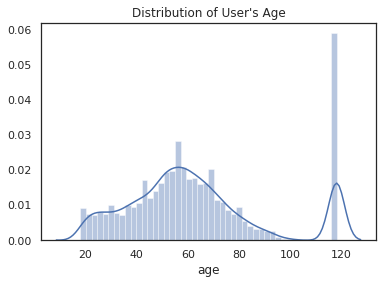

In [167]:
plt.figure()
plt.title('Distribution of User\'s Age')
sns.distplot(profile['age'])
plt.show()

After the distribution has been drawn for age, it seems like 118 is indeed used to encode a missing age as there are abnormally high occurences of it. It will be treated as `np.NaN` instead for now.

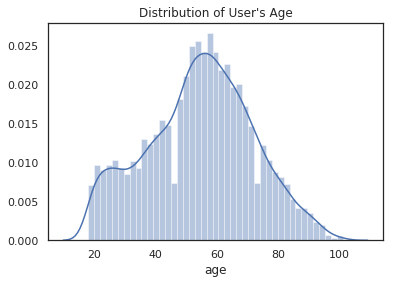

In [168]:
# Replace with np.NaN
profile['age'] = profile['age'].replace(118, np.NaN)

plt.figure()
plt.title('Distribution of User\'s Age')
sns.distplot(profile['age'].dropna())
plt.show()

Re-drawing the distribution with the missing values yields the graph above. It looks like the age of the customer's base is somewhat centered around 50-70 years old.

### 1.2.2 Income

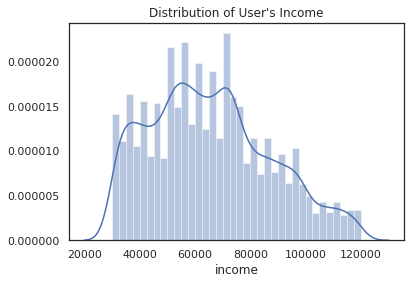

In [169]:
plt.figure()
plt.title('Distribution of User\'s Income')
sns.distplot(profile['income'].dropna())
plt.show()

It does not seem that there are anomalous values for the income. The slight peaks in the distribution is most probably caused by people rounding up/down their income values when they report the income in the app.

### 1.2.3 Missing Data

In this section, we will deal with the missing data in the profile table. 

In [170]:
display(profile.head())

,age,became_member_on,gender,id,income
0,NaN,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,NaN,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,NaN,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


Taking a quick glance at the head of the dataframe above, it seems that a user either have complete or no data, which will be verified in the section below:

In [171]:
profile['row_missing_count'] = profile[['age', 'gender', 'income']].isnull().sum(axis=1)

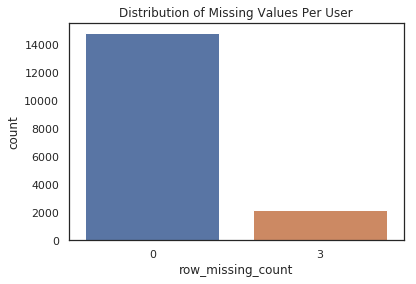

In [172]:
plt.figure()
plt.title('Distribution of Missing Values Per User')
sns.countplot(profile['row_missing_count'])
plt.show()

The above hypothesis was verified. It looks like in the data, user either have complete data or all missing data. 

There are two choices in dealing with these users, either impute their values or drop them from the analysis altogether. 

Dropping them seems like a better option here as if we are to impute the data, these ~2k users will have the same value for all three columns (`age`, `gender`, `income`) and they will provide no additional information.

In [173]:
# Subset the users only to those with 0 missing values
profile = profile[profile['row_missing_count'] == 0]

In [174]:
# Rename the id column to standardize with other tables
profile = profile.drop(['row_missing_count'], axis=1)

profile = profile.rename(columns={
    'id' : 'profile_id'
})

### 1.2.4 Gender

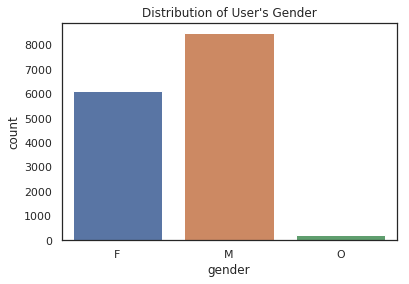

M    0.572277
F    0.413423
O    0.014300
Name: gender, dtype: float64

In [175]:
plt.figure()
plt.title('Distribution of User\'s Gender')
sns.countplot(profile['gender'].dropna())
plt.show()

display(profile['gender'].value_counts() / len(profile))

Starbucks have more male customers (57%) compared to the female ones.

Gender will then be one-hot encoded to the columns `M`, `F` and `O`.

In [176]:
gender_dummy_df = pd.get_dummies(profile['gender'])

profile = profile.join(gender_dummy_df)

profile = profile.drop(['gender'], axis=1)

### 1.2.5 Tenure

In [177]:
display(profile['became_member_on'].head())

1     20170715
3     20170509
5     20180426
8     20180209
12    20171111
Name: became_member_on, dtype: int64

As shown above, the date when a user becomes a Starbucks member is stored in the format of `%Y%m%d `

This column will be transformed into a feature representing tenure (ie. How long has someone been a Starbucks member). 

In doing so, a date in the future will be taken as a reference date, and the difference in days/months to the day the user became a member will be generated as the tenure.

Selecting any date that is within a reasonable range from the latest user sign-up date should work in this case as the distance between user's sign-up dates is preserved. By reasonable range, it means that the base difference should not overwhelm the variance across user's sign-up values.

In [178]:
print('Max user sign up date :', profile['became_member_on'].max())

Max user sign up date : 20180726


Here we can see that the latest signup_date in the data is 26th July 2018. We will proceed to use 1st January 2019 as the reference date to calculate user's tenure as the number of days that has passed between user's sign up to 1st January 2019.

In [179]:
profile['ref_date'] = '20190101'

In [180]:
profile['became_member_on'] = profile['became_member_on'].astype(str)
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'])
profile['ref_date'] = pd.to_datetime(profile['ref_date'])

In [181]:
profile['tenure'] = profile['ref_date'] - profile['became_member_on']
profile['tenure'] = profile['tenure'].astype('timedelta64[D]')

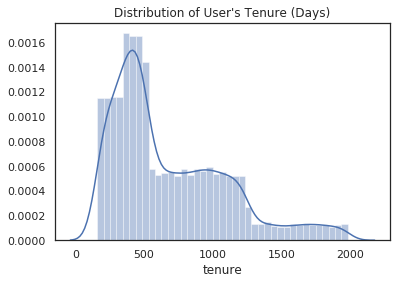

In [182]:
plt.figure()
plt.title('Distribution of User\'s Tenure (Days)')
sns.distplot(profile['tenure'])
plt.show()

In [183]:
# Drop the original column and the reference date helper column
profile = profile.drop(['became_member_on', 'ref_date'], axis=1)

In [184]:
display(profile.head())

,age,profile_id,income,F,M,O,tenure
1,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,0,535.0
3,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,0,602.0
5,68.0,e2127556f4f64592b11af22de27a7932,70000.0,0,1,0,250.0
8,65.0,389bc3fa690240e798340f5a15918d5c,53000.0,0,1,0,326.0
12,58.0,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,1,0,416.0


## 1.3. Transcript

In [185]:
display(transcript.head())

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [186]:
# Standardize the id to join with the profile table
transcript = transcript.rename(columns={
    'person' : 'profile_id'
})

In [187]:
print(transcript['event'].drop_duplicates().values)

['offer received' 'offer viewed' 'transaction' 'offer completed']


The event data is stored in a generic table where it records the user, time, and the metadata of the event. 

There are 4 possible events in the dataset: 

1. Offer Received
2. Offer Viewed
3. Offer Completed
4. Transaction

Subsets of dataframe containing each of these events will be explored to better understand the way to parse the metadata.

In [188]:
# Generate subsets of the main table based on the event type
received_df = transcript[transcript['event'] == 'offer received']
viewed_df = transcript[transcript['event'] == 'offer viewed']
completed_df = transcript[transcript['event'] == 'offer completed']
txn_df = transcript[transcript['event'] == 'transaction']

### 1.3.1 Offer Received Event

In [189]:
display(received_df.head())

,event,profile_id,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


Here, the `value` column stores the offer id of the particular offer. We will proceed to extract it into a column named `offer_id`, following the same notation we used for the `portfolio` table.

In [190]:
received_df['offer_id'] = received_df['value'].apply(lambda x: x['offer id'])

We will also rename the `time` column as `received_time` to allow joining with the other events to get a complete journey view on a particular offer-person pair (i.e. to later be joined with view & complete event)

In [191]:
received_df = received_df.rename(columns={
    'time' : 'received_time'
})

received_df = received_df.drop(['event', 'value'], axis=1)

As each offer has a validity period (ie. Expiry) captured in the `duration` column of the `portfolio` dataframe, we will join the `portfolio` table to obtain the said information. 

We will then create a column called `expiry_time` that marks the time (in hours) on which the validity of the offer will be deemed invalid.

In [192]:
received_df = received_df.merge(portfolio, on=['offer_id'])

In [193]:
received_df['expiry_time'] = received_df['received_time'] + 24 * received_df['duration']
received_df['expiry_time'] = received_df['expiry_time'].astype(int)

In [194]:
display(received_df.head())

,profile_id,received_time,offer_id,difficulty,duration,offer_type,reward,is_email,is_web,is_mobile,is_social,expiry_time
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,1,0,168
1,ebe7ef46ea6f4963a7dd49f501b26779,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,1,0,168
2,f082d80f0aac47a99173ba8ef8fc1909,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,1,0,168
3,c0d210398dee4a0895b24444a5fcd1d2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,1,0,168
4,57dd18ec5ddc46828afb81ec5977bef2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,1,0,168


### 1.3.2 Offer Viewed Event

In [195]:
display(viewed_df.head())

,event,profile_id,time,value
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
12651,offer viewed,d1ede868e29245ea91818a903fec04c6,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
12652,offer viewed,102e9454054946fda62242d2e176fdce,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
12653,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
12655,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}


Similar to the offer received event, the offer id her will be extracted using the `offer id` key.

In [196]:
viewed_df['offer_id'] = viewed_df['value'].apply(lambda x: x['offer id'])

And `time` column will be renamed to `viewed_time`.

In [197]:
viewed_df = viewed_df.rename(columns={
    'time' : 'viewed_time'
})


viewed_df['viewed_time'] = viewed_df['viewed_time'].astype(int)


viewed_df = viewed_df.drop(['event', 'value'], axis=1)

In [198]:
display(viewed_df.head())

,profile_id,viewed_time,offer_id
12650,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d
12651,d1ede868e29245ea91818a903fec04c6,0,5a8bc65990b245e5a138643cd4eb9837
12652,102e9454054946fda62242d2e176fdce,0,4d5c57ea9a6940dd891ad53e9dbe8da0
12653,02c083884c7d45b39cc68e1314fec56c,0,ae264e3637204a6fb9bb56bc8210ddfd
12655,be8a5d1981a2458d90b255ddc7e0d174,0,5a8bc65990b245e5a138643cd4eb9837


### 1.3.3 Offer Completed Event

In [199]:
display(completed_df.head())

,event,profile_id,time,value
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
12679,offer completed,629fc02d56414d91bca360decdfa9288,0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
12692,offer completed,676506bad68e4161b9bbaffeb039626b,0,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...
12697,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...


Here, we observe a slight difference in the key used to extract the offer id. Instead of `offer id` used previously, the key used here will be `offer_id`.

In [200]:
completed_df['offer_id'] = completed_df['value'].apply(lambda x: x['offer_id'])

Rename `time` column to `completed_time`.

In [201]:
completed_df = completed_df.rename(columns={
    'time' : 'completed_time'
})


completed_df['completed_time'] = completed_df['completed_time'].astype(int)


completed_df = completed_df.drop(['event', 'value'], axis=1)

In [202]:
display(completed_df.head())

,profile_id,completed_time,offer_id
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2906b810c7d4411798c6938adc9daaa5
12672,fe97aa22dd3e48c8b143116a8403dd52,0,fafdcd668e3743c1bb461111dcafc2a4
12679,629fc02d56414d91bca360decdfa9288,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
12692,676506bad68e4161b9bbaffeb039626b,0,ae264e3637204a6fb9bb56bc8210ddfd
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,4d5c57ea9a6940dd891ad53e9dbe8da0


### 1.3.4 Combining Received and Viewed Event

In this section, we will be combining the `received` and `viewed` event of a particular offer sent to a person.

In [203]:
# Left join the received event and viewed event on profile_id and offer_id
receive_and_view = received_df.merge(viewed_df, on=['profile_id', 'offer_id'], how='left')

In [204]:
print('Received and View row count:', len(receive_and_view))
print('Original Viewed event count:', len(viewed_df))

Received and View row count: 95321
Original Viewed event count: 57725


There is a problem here that the joined table ended up having more row than the original view event table. This is most likely caused by a particular person receiving a same offer type more than once.

We will establish the first logic that will be used, that 

`viewed_time` >= `received_time`

to filter out some of the duplicate view assignment mentioned above.

In [205]:
receive_and_view = receive_and_view[
    (receive_and_view['viewed_time'] >= receive_and_view['received_time'])
]

In [206]:
print('Received and View row count:', len(receive_and_view))
print('Original Viewed event count:', len(viewed_df))

Received and View row count: 68404
Original Viewed event count: 57725


There is an improvement, but some view events are still assigned to more than received event.

In the following section, we will perform more filtering to ensure that there is a unique, one-to-one mapping between a view event and a received event, meaning: 

1. A view event can only be assigned to one received event 
2. A receive event can only have one view event assigned to it


In [207]:
# Check which views are assigned to more than 1 received event.
view_count = receive_and_view.groupby(['profile_id', 'offer_id', 'viewed_time'])['received_time'].count().reset_index()

duplicated_view_count = view_count[view_count['received_time'] > 1].sort_values(by='received_time', ascending=False)

non_duplicated_view_count = view_count[view_count['received_time'] == 1]

display(duplicated_view_count.head())

# Take only the relevant columns
duplicated_view_count = duplicated_view_count[['profile_id', 'offer_id', 'viewed_time']]
non_duplicated_view_count = non_duplicated_view_count[['profile_id', 'offer_id', 'viewed_time']]

,profile_id,offer_id,viewed_time,received_time
53868,eece6a9a7bdd4ea1b0f812f34fc619d6,5a8bc65990b245e5a138643cd4eb9837,576.0,5
10189,2ea50de315514ccaa5079db4c1ecbc0b,fafdcd668e3743c1bb461111dcafc2a4,576.0,5
7653,23d67a23296a485781e69c109a10a1cf,5a8bc65990b245e5a138643cd4eb9837,582.0,5
24531,6d2db3aad94648259e539920fc2cf2a6,f19421c1d4aa40978ebb69ca19b0e20d,588.0,5
42113,b993a783cfe844848fc165a1de3926b1,3f207df678b143eea3cee63160fa8bed,582.0,4


As an example, a viewing event belonging to person `eece6a9a7bdd4ea1b0f812f34fc619d6` towards offer `5a8bc65990b245e5a138643cd4eb9837`, happening at time `576`, has been assigned to 5 different offer received events.

In [208]:
# Show the complete receive and view data for the particular person-offer combination
display(receive_and_view.merge(duplicated_view_count.head(1)[['profile_id', 'offer_id']], on=['profile_id', 'offer_id']))

,profile_id,received_time,offer_id,difficulty,duration,offer_type,reward,is_email,is_web,is_mobile,is_social,expiry_time,viewed_time
0,eece6a9a7bdd4ea1b0f812f34fc619d6,0,5a8bc65990b245e5a138643cd4eb9837,0,3,informational,0,1,0,1,1,72,90.0
1,eece6a9a7bdd4ea1b0f812f34fc619d6,0,5a8bc65990b245e5a138643cd4eb9837,0,3,informational,0,1,0,1,1,72,174.0
2,eece6a9a7bdd4ea1b0f812f34fc619d6,0,5a8bc65990b245e5a138643cd4eb9837,0,3,informational,0,1,0,1,1,72,414.0
3,eece6a9a7bdd4ea1b0f812f34fc619d6,0,5a8bc65990b245e5a138643cd4eb9837,0,3,informational,0,1,0,1,1,72,516.0
4,eece6a9a7bdd4ea1b0f812f34fc619d6,0,5a8bc65990b245e5a138643cd4eb9837,0,3,informational,0,1,0,1,1,72,576.0
5,eece6a9a7bdd4ea1b0f812f34fc619d6,168,5a8bc65990b245e5a138643cd4eb9837,0,3,informational,0,1,0,1,1,240,174.0
6,eece6a9a7bdd4ea1b0f812f34fc619d6,168,5a8bc65990b245e5a138643cd4eb9837,0,3,informational,0,1,0,1,1,240,414.0
7,eece6a9a7bdd4ea1b0f812f34fc619d6,168,5a8bc65990b245e5a138643cd4eb9837,0,3,informational,0,1,0,1,1,240,516.0
8,eece6a9a7bdd4ea1b0f812f34fc619d6,168,5a8bc65990b245e5a138643cd4eb9837,0,3,informational,0,1,0,1,1,240,576.0
9,eece6a9a7bdd4ea1b0f812f34fc619d6,408,5a8bc65990b245e5a138643cd4eb9837,0,3,informational,0,1,0,1,1,480,414.0


The dataframe above shows the complete receive and view events of the particular person and offer combination, and turns out: 

Person `eece6a9a7bdd4ea1b0f812f34fc619d6` received the offer `5a8bc65990b245e5a138643cd4eb9837` five times, at time `0`, `168`, `408`, `504` and `576` respectively.

He/she also viewed the same offer type five times, at time `90`, `174`, `414`, `516`, and `576` respectively. 

Because the only filtering that we did was that `viewed_time` must be larger or equal `received_time`, the view event that happened at time `576` was assigned to all five received offers, explaining the phenomenon above.

In order to assign a unique 1-1 mapping for each `received` and `viewed` event, we will assume that the viewing order follows a last-in-first-out order, as the order they appear in the user's notification page/inbox should be earlier. 

For example:

1. Person `A` receives a particular offer `1` two times, at timestamp `0` and `10`
2. Person `A` has 1 view event for offer `1`, happening at timestamp `15`
3. The single view event will be assigned to the offer received at timestamp `10`

In [209]:
# Get the non-duplicated views
non_duplicated_views = receive_and_view.merge(non_duplicated_view_count, on=['profile_id', 'offer_id', 'viewed_time'])

# Add helper column
non_duplicated_views['not_duplicated'] = 1

# Create a helper dataframe to exclude a particular offer received instance from the duplicated table.
# This will prevent a particular offer received instance having more than one view event assigned to it
checker_viewed = non_duplicated_views[['profile_id', 'offer_id', 'received_time', 'not_duplicated']].drop_duplicates()

duplicated_views = receive_and_view.merge(duplicated_view_count, on=['profile_id', 'offer_id', 'viewed_time'])
duplicated_views = duplicated_views.merge(checker_viewed, on=['profile_id','offer_id','received_time'], how='left')
duplicated_views['not_duplicated'] = duplicated_views['not_duplicated'].fillna(0)

# Remove the offer received instances that are already in the not_duplicated table
duplicated_views = duplicated_views[duplicated_views['not_duplicated'] == 0]

In [214]:
display(duplicated_views.head())

,profile_id,received_time,offer_id,difficulty,duration,offer_type,reward,is_email,is_web,is_mobile,is_social,expiry_time,viewed_time,not_duplicated,same_offer_receive_order,same_offer_view_order
0,ebe7ef46ea6f4963a7dd49f501b26779,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,1,0,168,714.0,0.0,1.0,1.0
1,ebe7ef46ea6f4963a7dd49f501b26779,576,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,1,0,744,714.0,0.0,2.0,1.0
3,32fbf97e89274e8a935903f2ad095e1f,336,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,1,0,504,360.0,0.0,1.0,1.0
5,d1a6fe4c241e4dbf8a4da6fd6c714ac5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,1,0,336,192.0,0.0,1.0,1.0
6,bbeb54e861614fc7b22a8844f72dca6c,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,1,0,168,528.0,0.0,1.0,1.0


The `receive` and `view` event will then be ranked (by time) according to our assumption above that offer that was received last will be viewed first. 

The unique assignment will happen by filtering the pairs of `view` and `receive` event that has the same rank.

To illustrate this process, we will use the same example as person `A` above:

1. Person `A` receives a particular offer `1` two times, at timestamp `0` and `10`
2. Person `A` has 1 view event for offer `1`, happening at timestamp `15`

The offer received at timestamp `10` will have a rank value of 1, while the one received at timestamp `0` will have a rank value of 2, following the last-in-first-out principle. 

The offer view event will have a rank value of 1, as there is only one viewing instance. 

Upon filtering `view_rank` == `received_rank`, we will have the offer view event assigned to the offer received at timestamp `10`.

In [215]:
# ascending=False reflects the last-in-first-out principle
duplicated_views['same_offer_receive_order'] = duplicated_views.sort_values(by='received_time', ascending=False)\
    .groupby(['profile_id', 'offer_id'])['received_time'].rank(method='dense')

duplicated_views['same_offer_view_order'] = duplicated_views.sort_values(by='viewed_time', ascending=True)\
    .groupby(['profile_id', 'offer_id'])['viewed_time'].rank(method='dense')

In [216]:
# Filter to pairs with same rank value
fixed_duplicated_views = duplicated_views[
    (duplicated_views['same_offer_receive_order'] == duplicated_views['same_offer_view_order'])
]

fixed_duplicated_views = fixed_duplicated_views.drop(['same_offer_receive_order', 'same_offer_view_order'], axis=1)

In [217]:
# Concatenate the fixed duplicate table with non_duplicate table filtered out earlier
receive_and_view = pd.concat([non_duplicated_views, fixed_duplicated_views])

We will then check the 1-1 mapping in the following section by counting the number of offer received events that a particular view is assigned to, and also counting the number of views assigned to a particular offer received event. 

If we have successfully done the mapping, the maximum count of both checks should be one.

In [218]:
# Check that one view event is assigned to only one received event
check_view_df = receive_and_view.groupby(['profile_id', 'offer_id', 'viewed_time'])['received_time']\
    .count().reset_index()

# Check that one received event is only assigned one view event
check_view_df_2 = receive_and_view.groupby(['profile_id', 'offer_id', 'received_time'])['viewed_time']\
    .count().reset_index()

display(check_view_df.sort_values(by=['received_time'], ascending=False).head())
display(check_view_df_2.sort_values(by=['viewed_time'], ascending=False).head())

,profile_id,offer_id,viewed_time,received_time
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,372.0,1
38447,a97e140cf0094644a99290c1172f7d18,2906b810c7d4411798c6938adc9daaa5,378.0,1
38477,a99e6dc6e2db4882a07f4280db7de088,ae264e3637204a6fb9bb56bc8210ddfd,528.0,1
38478,a99e6dc6e2db4882a07f4280db7de088,f19421c1d4aa40978ebb69ca19b0e20d,594.0,1
38479,a99e6dc6e2db4882a07f4280db7de088,fafdcd668e3743c1bb461111dcafc2a4,450.0,1


,profile_id,offer_id,received_time,viewed_time
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336,1
38447,a97e140cf0094644a99290c1172f7d18,2906b810c7d4411798c6938adc9daaa5,336,1
38477,a99e6dc6e2db4882a07f4280db7de088,ae264e3637204a6fb9bb56bc8210ddfd,504,1
38478,a99e6dc6e2db4882a07f4280db7de088,f19421c1d4aa40978ebb69ca19b0e20d,576,1
38479,a99e6dc6e2db4882a07f4280db7de088,fafdcd668e3743c1bb461111dcafc2a4,408,1


In [219]:
print('Received and View row count:', len(receive_and_view))
print('Original Viewed event count:', len(viewed_df))

Received and View row count: 57725
Original Viewed event count: 57725


As both checks have the maximum value of 1, we can verify that the 1-1 assignment has been done correctly.

The number of rows in both the processed and raw table tallying also verifies this.

In [220]:
# Subset to relevant columns only
receive_and_view = receive_and_view[['profile_id', 'received_time', 'offer_id', 'viewed_time']]

### 1.3.5 Combining Received and Completed Event

Combining received and completed event will follow a similar procedure with combining received and viewed event. 

However, there is a difference between completed and viewed event table that will hinder us from purely re-using the method above, that is in the completed table, there are cases where at a same point of time, a particular customers completes more than one instances of the same offer. 

This becomes a problem as the .rank() method used above will register the same rank for all three completed instances. As we rely on the rank to pair the events, then this method will fail. 

In [221]:
# Initialize a helper dummy variable 
completed_df['dummy_count'] = 1

In [222]:
display(completed_df.groupby(['profile_id', 'offer_id', 'completed_time'])['dummy_count']\
        .sum().sort_values(ascending=False).reset_index().head())

,profile_id,offer_id,completed_time,dummy_count
0,3526938fb466470190a504a751ec07b0,0b1e1539f2cc45b7b9fa7c272da2e1d7,510,3
1,6fa9ef8890bc467699ce92f2679a4178,f19421c1d4aa40978ebb69ca19b0e20d,624,2
2,9b2ec72a4ee04bb1bbf360642f22e7d3,fafdcd668e3743c1bb461111dcafc2a4,630,2
3,b669b308d4fa4bff837d68d86a78e6b1,9b98b8c7a33c4b65b9aebfe6a799e6d9,510,2
4,d19849e046cc441fb7cfc4c8a68dbf6d,0b1e1539f2cc45b7b9fa7c272da2e1d7,600,2


The dataframe above shows that person `3526938fb466470190a504a751ec07b0` completes the offer `0b1e1539f2cc45b7b9fa7c272da2e1d7` three times, all at the same timestamp of `510`

To prevent the instances from being assigned the same rank, we will assign a particular number `dummy_rank` that signifies the running number of occurence of a particular complete event.

The same .rank() method will be used, albeit with the argument `method='first'`

In [223]:
completed_df['dummy_rank'] = completed_df.groupby(['profile_id', 'offer_id', 'completed_time'])['dummy_count']\
    .rank(method='first')

In [224]:
display(completed_df[
    (completed_df['profile_id'] == '3526938fb466470190a504a751ec07b0') &
    (completed_df['offer_id'] == '0b1e1539f2cc45b7b9fa7c272da2e1d7')
])

,profile_id,completed_time,offer_id,dummy_count,dummy_rank
220615,3526938fb466470190a504a751ec07b0,510,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1.0
220616,3526938fb466470190a504a751ec07b0,510,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,2.0
220617,3526938fb466470190a504a751ec07b0,510,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,3.0


Now, the three completed events have different ranks, and this will be to generate a dummy time variable `dummy_completed_time`, by which we will order the completed events and assign the rank.

In [225]:
# Generate dummy_completed_time by adding 0.1 of dummy_rank to completed_time
completed_df['dummy_completed_time'] = completed_df['completed_time'] + completed_df['dummy_rank'] / 10

We will proceed with similar steps to assign a 1-1 mapping between the `received` and `completed` events.

In [226]:
# Initial join between received and completed tables, this will yield duplicated completed events
receive_and_complete = received_df.merge(completed_df, on=['profile_id', 'offer_id'])

In addition to the logic of `completed_time` must be larger than or equal of `received_time`, there is another logic that needs to be imposed, that `completed_time` must be smaller than or equal of `expiry_time` that marks the end of validity of a particular offer.

In [227]:
receive_and_complete = receive_and_complete[
    (receive_and_complete['completed_time'] >= receive_and_complete['received_time']) &
    (receive_and_complete['completed_time'] <= receive_and_complete['expiry_time'])
]

In [228]:
print('Received and Completed row count:', len(receive_and_complete))
print('Original Completed event count:', len(completed_df))

Received and Completed row count: 35376
Original Completed event count: 33579


As expected, the number of rows in the joined table exceeds the raw completed event count. 

We will take similar steps with joining the view event, albeit using `dummy_completed_time` to generate the ranks, also, the logic of assigning the completed event will follow a first-in-first-out order, for example:

1. Person `A` receives a particular offer `1` two times, at timestamp `0` and `10`
2. Person `A` has 1 completed event for offer `1`, happening at timestamp `15`

The completed event will be assigned to the offer received at timestamp `0`.

In [229]:
# Get completed events assigned to more than one received event
complete_count = receive_and_complete.groupby(['profile_id', 'offer_id', 'completed_time'])['received_time'].count().reset_index()
duplicated_complete_count = complete_count[complete_count['received_time'] > 1].sort_values(by='received_time', ascending=False)

# Get the non duplicated completed events
non_duplicated_complete_count = complete_count[complete_count['received_time'] == 1]

display(duplicated_complete_count.head())

# Subset only the relevant columns
duplicated_complete_count = duplicated_complete_count[['profile_id', 'offer_id', 'completed_time']]
non_duplicated_complete_count = non_duplicated_complete_count[['profile_id', 'offer_id', 'completed_time']]

,profile_id,offer_id,completed_time,received_time
6860,3526938fb466470190a504a751ec07b0,0b1e1539f2cc45b7b9fa7c272da2e1d7,510,9
6920,35b3206b05304a518114bee3e113af09,9b98b8c7a33c4b65b9aebfe6a799e6d9,576,6
5994,2ea50de315514ccaa5079db4c1ecbc0b,fafdcd668e3743c1bb461111dcafc2a4,528,6
11731,5a7136999fa240838c28e52359f6533d,fafdcd668e3743c1bb461111dcafc2a4,618,6
19873,99148a450059428180ed37cb9ab01f62,2906b810c7d4411798c6938adc9daaa5,642,4


In [230]:
display(receive_and_complete.merge(duplicated_complete_count.head(1)[['profile_id', 'offer_id']], on=['profile_id', 'offer_id']))

,profile_id,received_time,offer_id,difficulty,duration,offer_type,reward,is_email,is_web,is_mobile,is_social,expiry_time,completed_time,dummy_count,dummy_rank,dummy_completed_time
0,3526938fb466470190a504a751ec07b0,336,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,1,1,0,0,576,510,1,1.0,510.1
1,3526938fb466470190a504a751ec07b0,336,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,1,1,0,0,576,510,1,2.0,510.2
2,3526938fb466470190a504a751ec07b0,336,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,1,1,0,0,576,510,1,3.0,510.3
3,3526938fb466470190a504a751ec07b0,408,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,1,1,0,0,648,510,1,1.0,510.1
4,3526938fb466470190a504a751ec07b0,408,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,1,1,0,0,648,510,1,2.0,510.2
5,3526938fb466470190a504a751ec07b0,408,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,1,1,0,0,648,510,1,3.0,510.3
6,3526938fb466470190a504a751ec07b0,504,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,1,1,0,0,744,510,1,1.0,510.1
7,3526938fb466470190a504a751ec07b0,504,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,1,1,0,0,744,510,1,2.0,510.2
8,3526938fb466470190a504a751ec07b0,504,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,1,1,0,0,744,510,1,3.0,510.3


In [231]:
non_duplicated_completes = receive_and_complete\
    .merge(non_duplicated_complete_count, on=['profile_id', 'offer_id', 'completed_time'])

non_duplicated_completes['not_duplicated'] = 1

# Create a helper table to exclude the received offers that has already been assigned a 
# non_duplicated completed event
checker_completed = non_duplicated_completes[['profile_id', 'offer_id', 'received_time', 'not_duplicated']].drop_duplicates()

duplicated_completes = receive_and_complete.merge(duplicated_complete_count, on=['profile_id', 'offer_id', 'completed_time'])
duplicated_completes = duplicated_completes.merge(checker_completed, on=['profile_id','offer_id','received_time'], how='left')

duplicated_completes['not_duplicated'] = duplicated_completes['not_duplicated'].fillna(0)
duplicated_completes = duplicated_completes[duplicated_completes['not_duplicated'] == 0]

In [232]:
# Create the ranking column, with first-in-first-out logic
duplicated_completes['same_offer_receive_order'] = duplicated_completes.sort_values(by='received_time', ascending=True).groupby(['profile_id', 'offer_id'])['received_time'].rank(method='dense')
duplicated_completes['same_offer_complete_order'] = duplicated_completes.sort_values(by='dummy_completed_time', ascending=True).groupby(['profile_id', 'offer_id'])['dummy_completed_time'].rank(method='dense')

In [233]:
duplicated_completes[duplicated_completes['profile_id'] == '3526938fb466470190a504a751ec07b0']

,profile_id,received_time,offer_id,difficulty,duration,offer_type,reward,is_email,is_web,is_mobile,is_social,expiry_time,completed_time,dummy_count,dummy_rank,dummy_completed_time,not_duplicated,same_offer_receive_order,same_offer_complete_order
434,3526938fb466470190a504a751ec07b0,336,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,1,1,0,0,576,510,1,1.0,510.1,0.0,1.0,1.0
435,3526938fb466470190a504a751ec07b0,336,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,1,1,0,0,576,510,1,2.0,510.2,0.0,1.0,2.0
436,3526938fb466470190a504a751ec07b0,336,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,1,1,0,0,576,510,1,3.0,510.3,0.0,1.0,3.0
437,3526938fb466470190a504a751ec07b0,408,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,1,1,0,0,648,510,1,1.0,510.1,0.0,2.0,1.0
438,3526938fb466470190a504a751ec07b0,408,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,1,1,0,0,648,510,1,2.0,510.2,0.0,2.0,2.0
439,3526938fb466470190a504a751ec07b0,408,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,1,1,0,0,648,510,1,3.0,510.3,0.0,2.0,3.0
440,3526938fb466470190a504a751ec07b0,504,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,1,1,0,0,744,510,1,1.0,510.1,0.0,3.0,1.0
441,3526938fb466470190a504a751ec07b0,504,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,1,1,0,0,744,510,1,2.0,510.2,0.0,3.0,2.0
442,3526938fb466470190a504a751ec07b0,504,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,1,1,0,0,744,510,1,3.0,510.3,0.0,3.0,3.0


In [234]:
# Filter out the pairing having same ranking
fixed_duplicated_completes = duplicated_completes[
    (duplicated_completes['same_offer_receive_order'] == duplicated_completes['same_offer_complete_order'])
]

fixed_duplicated_completes = fixed_duplicated_completes.drop(['same_offer_receive_order', 'same_offer_complete_order'], axis=1)

In [235]:
receive_and_complete = pd.concat([non_duplicated_completes, fixed_duplicated_completes])

In [236]:
# Check that one complete event is assigned to only one received event
check_complete_df = receive_and_complete.groupby(['profile_id', 'offer_id', 'completed_time'])['received_time'].count().reset_index()

# Check that one received event is only paired to one completed event
check_complete_df_2 = receive_and_complete.groupby(['profile_id', 'offer_id', 'received_time'])['completed_time'].count().reset_index()

display(check_complete_df.sort_values(by=['received_time'], ascending=False).head())
display(check_complete_df_2.sort_values(by=['completed_time'], ascending=False).head())

,profile_id,offer_id,completed_time,received_time
6860,3526938fb466470190a504a751ec07b0,0b1e1539f2cc45b7b9fa7c272da2e1d7,510,3
18099,8b9d3f738e7e499b9e820de07c16bc62,2906b810c7d4411798c6938adc9daaa5,630,2
13727,69743d51492d4173b0e054fd5d8f943c,f19421c1d4aa40978ebb69ca19b0e20d,576,2
14244,6d6c0aa032064438b97ab5dc28fd1b61,9b98b8c7a33c4b65b9aebfe6a799e6d9,432,2
2010,0f6cf9619c4341e89a099e951300a2ea,0b1e1539f2cc45b7b9fa7c272da2e1d7,552,2


,profile_id,offer_id,received_time,completed_time
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576,1
22396,a960ae2cd3d04791ac3ca5799a2ad01a,2298d6c36e964ae4a3e7e9706d1fb8c2,0,1
22394,a95c94e9e8444d3ea4e10d2b96c6bba4,ae264e3637204a6fb9bb56bc8210ddfd,0,1
22393,a95c8b2d84b04c22b525d6fec9e1dda3,fafdcd668e3743c1bb461111dcafc2a4,336,1
22392,a95c8b2d84b04c22b525d6fec9e1dda3,9b98b8c7a33c4b65b9aebfe6a799e6d9,576,1


In [237]:
print('Received and Completed row count:', len(receive_and_complete))
print('Original Completed event count:', len(completed_df))

Received and Completed row count: 33579
Original Completed event count: 33579


With the same checking logic with viewing event, and as both of the tables have their row numbers tally, we can verify that we have managed to do 1-1 mapping of the completed event to the received ones.

In [238]:
# Subset the relevant columns
receive_and_complete = receive_and_complete[['profile_id', 'received_time', 'offer_id', 'completed_time']]

We then merge the three tables `received_df`, `receive_and_view` and `receive_and_complete` to complete the detail of a particular offer-person pair. 

We will store this table called `experiment_df`.

In [239]:
experiment_df = received_df.merge(receive_and_view, on=['profile_id', 'received_time', 'offer_id'], how='left')\
    .merge(receive_and_complete, on=['profile_id', 'received_time', 'offer_id'], how='left')

To assist with labeling the offer-person pair, we will give label `True` if the `viewed_time`/`completed_time` is not `NULL`, else the label will be `False`

In [240]:
experiment_df['is_viewed'] = pd.notnull(experiment_df['viewed_time'])
experiment_df['is_completed'] = pd.notnull(experiment_df['completed_time'])

In [241]:
display(experiment_df.head())

,profile_id,received_time,offer_id,difficulty,duration,offer_type,reward,is_email,is_web,is_mobile,is_social,expiry_time,viewed_time,completed_time,is_viewed,is_completed
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,1,0,168,6.0,132.0,True,True
1,ebe7ef46ea6f4963a7dd49f501b26779,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,1,0,168,714.0,NaN,True,False
2,f082d80f0aac47a99173ba8ef8fc1909,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,1,0,168,48.0,12.0,True,True
3,c0d210398dee4a0895b24444a5fcd1d2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,1,0,168,30.0,66.0,True,True
4,57dd18ec5ddc46828afb81ec5977bef2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,1,0,168,NaN,NaN,False,False


### 1.3.6 Transactions Data

In this section, we will also incorporate transactions data into the `experiment_df`. 

In [242]:
display(txn_df.head())

,event,profile_id,time,value
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001}
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23}
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51}
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97}


The transactions are stored in a dictionary with `amount` as key. We will proceed to extract the transaction values by using a dictionary lookup.

In [106]:
txn_df['amount'] = txn_df['value'].apply(lambda x: x['amount'])

In [107]:
# Rename the column to txn_time
txn_df = txn_df.rename(columns={
    'time' : 'txn_time', 
})

# Drop irrelevant columns
txn_df = txn_df.drop(['event', 'value'], axis=1)

We will now take a look at the transaction data to inspect the possibility of anomalous/outlier data such as very large amount of transactions and/or negative transactions, etc.

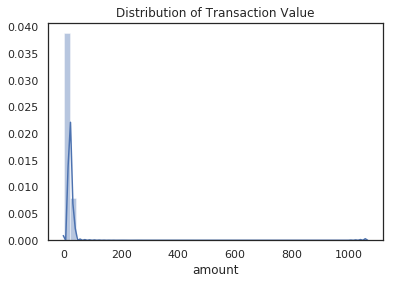

In [108]:
plt.figure()
plt.title('Distribution of Transaction Value')
sns.distplot(txn_df['amount'])
plt.show()

The distribution of transactions here clearly shows that there are outlier transactions with huge amounts. 

Considering that on average, a Starbucks order should be around $10 and below, we should consider to remove these points to avoid them from skewing the results.

We will try to set an upper limit based on the 99th percentile of the transaction amount (so that we are not cutting too much data, and if the amount is still too large we will adjust accordingly)

40.02


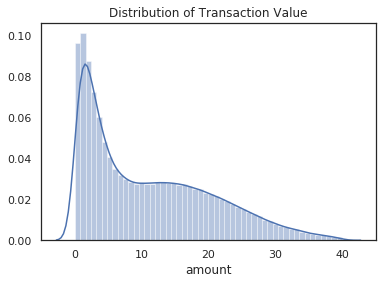

In [109]:
upper_lim  = np.percentile(txn_df['amount'], 99)
print(np.round(upper_lim, 2))

txn_df = txn_df[txn_df['amount'] <= upper_lim]


plt.figure()
plt.title('Distribution of Transaction Value')
sns.distplot(txn_df['amount'])
plt.show()

The 99th percentile value of the transaction value is 40.02. This still makes sense, and hence will be used to remove the outliers in our data.

We will then proceed to merge `experiment_df` with `txn_df` to get the transactions in between the different time periods of an experiment. Possible pairings:

1. Between `received_time` and `viewed_time`
2. Between `viewed_time` and `completed_time`
3. Between `received_time` and `completed_time`
4. Between `received_time` and `expiry_time`
5. Before time = 0 and `received_time`

In [110]:
exp_txns_df = experiment_df[['profile_id', 'offer_id', 'received_time', 'viewed_time', 'completed_time', 'expiry_time']]\
    .merge(txn_df, on=['profile_id'])

632057


In [111]:
between_received_and_view = (exp_txns_df['txn_time'] >= exp_txns_df['received_time'])\
    &(exp_txns_df['txn_time'] <= exp_txns_df['viewed_time'])
    
between_view_and_complete = (exp_txns_df['txn_time'] >= exp_txns_df['viewed_time'])\
    &(exp_txns_df['txn_time'] <= exp_txns_df['completed_time'])

between_received_and_complete = (exp_txns_df['txn_time'] >= exp_txns_df['received_time'])\
    &(exp_txns_df['txn_time'] <= exp_txns_df['completed_time'])

between_received_and_expiry = (exp_txns_df['txn_time'] >= exp_txns_df['received_time'])\
    &(exp_txns_df['txn_time'] <= exp_txns_df['expiry_time'])

before_received = (exp_txns_df['txn_time'] < exp_txns_df['received_time'])


exp_txns_df['between_received_and_view_amount'] = np.where(between_received_and_view, exp_txns_df['amount'], 0)
exp_txns_df['between_view_and_complete_amount'] = np.where(between_view_and_complete, exp_txns_df['amount'], 0)
exp_txns_df['between_received_and_complete_amount'] = np.where(between_received_and_complete, exp_txns_df['amount'], 0)
exp_txns_df['between_received_and_expiry_amount'] = np.where(between_received_and_expiry, exp_txns_df['amount'], 0)
exp_txns_df['before_received_amount'] = np.where(before_received, exp_txns_df['amount'], 0)


exp_txns_df['between_received_and_view_count'] = np.where(between_received_and_view, 1, 0)
exp_txns_df['between_view_and_complete_count'] = np.where(between_view_and_complete, 1, 0)
exp_txns_df['between_received_and_complete_count'] = np.where(between_received_and_complete, 1, 0)
exp_txns_df['between_received_and_expiry_count'] = np.where(between_received_and_expiry, 1, 0)
exp_txns_df['before_received_count'] = np.where(before_received, 1, 0)

cols_to_be_summed = [i for i in exp_txns_df.columns if 'between' in i or 'before' in i]

Sum the transactions in each offer-person pairing to get the amount of dollars transacted in the specified time periods.

In [112]:
exp_txns_df = exp_txns_df.groupby(['profile_id', 'offer_id', 'received_time'])[cols_to_be_summed]\
    .sum().reset_index()

In [113]:
full_data_df = experiment_df.merge(exp_txns_df, on=['profile_id', 'offer_id', 'received_time'], how='left')\
    .merge(profile, on=['profile_id'])

Fill the missing transactional with `0` to facilitate usage of machine learning models going forward.

In [114]:
for col in cols_to_be_summed:
    full_data_df[col] = full_data_df[col].fillna(0)

In [250]:
print(completed_df.merge(portfolio[['offer_id', 'offer_type']], on=['offer_id'])['offer_type']\
          .drop_duplicates().values)

['discount' 'bogo']


In the raw data, only `bogo` and `discount` have the completed events. 

In order for us to assess the effectiveness of `informational` offers, we will have to create a logic to assign a `completed` event. 

We will consider an `informational` offer to be completed if in between `received_time` and `expiry_time`, the user makes a transaction

In [115]:
# Completion logic for informational offers
informational_complete = (full_data_df['offer_type'] == 'informational') & (full_data_df['between_received_and_expiry_amount'] > 0)
full_data_df['is_completed'] = np.where(informational_complete, 1, full_data_df['is_completed'])

The purpose of this analysis is to identify the set of customers to which it is ideal to send offers to. 

The ideal case will be that someone views the offer, and subsequently completes it. Offers can be completed without having the user view it, and this is not ideal as these users would have transacted without an offer, and it will be a wasted marketing budget.

We will proceed to define the target variable as `ideal_to_send`, will have the value of `1` if the offer is both viewed and completed, and `0` otherwise.

In [116]:
ideal_to_send = (full_data_df['is_viewed'] == 1) & (full_data_df['is_completed'] == 1)
full_data_df['ideal_to_send'] = np.where(ideal_to_send, 1, 0)

In [117]:
full_data_df.head()

,profile_id,received_time,offer_id,difficulty,duration,offer_type,reward,is_email,is_web,is_mobile,...,between_received_and_complete_count,between_received_and_expiry_count,before_received_count,age,income,F,M,O,tenure,ideal_to_send
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,1,...,1.0,2.0,0.0,75.0,100000.0,1,0,0,602.0,1
1,78afa995795e4d85b5d9ceeca43f5fef,504,f19421c1d4aa40978ebb69ca19b0e20d,5,5,bogo,5,1,1,1,...,1.0,2.0,5.0,75.0,100000.0,1,0,0,602.0,1
2,78afa995795e4d85b5d9ceeca43f5fef,408,ae264e3637204a6fb9bb56bc8210ddfd,10,7,bogo,10,1,0,1,...,1.0,2.0,5.0,75.0,100000.0,1,0,0,602.0,1
3,78afa995795e4d85b5d9ceeca43f5fef,168,5a8bc65990b245e5a138643cd4eb9837,0,3,informational,0,1,0,1,...,0.0,2.0,2.0,75.0,100000.0,1,0,0,602.0,1
4,ebe7ef46ea6f4963a7dd49f501b26779,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,1,...,0.0,1.0,0.0,59.0,41000.0,0,1,0,1441.0,0


# 2. Creating A Baseline Model Based on Demographics

We will first try to build a simple model that utilizes only the demographics of the users: 

1. Income
2. Age
3. Tenure 

We will divide the users into different groups based on these features, and subsequently use the percentage of people that are `ideal_to_send` in the group for each offer as the probability that the group is the ideal target for that particular offer.

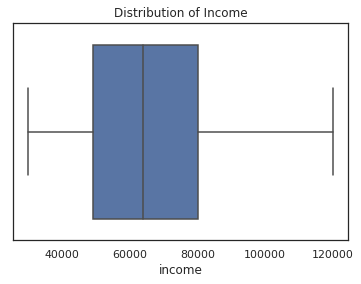

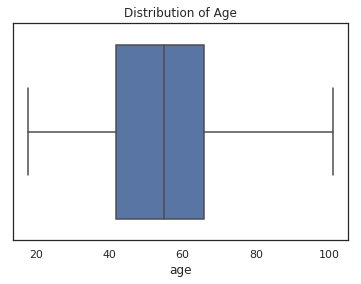

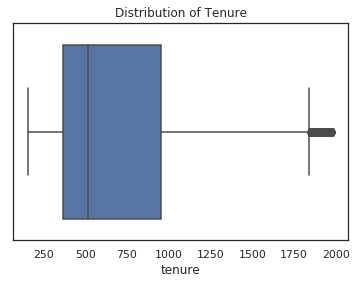

In [118]:
plt.figure()
plt.title('Distribution of Income')
sns.boxplot(profile['income'])
plt.show()

plt.figure()
plt.title('Distribution of Age')
sns.boxplot(profile['age'])
plt.show()

plt.figure()
plt.title('Distribution of Tenure')
sns.boxplot(profile['tenure'])
plt.show()

In [276]:
# Assign Income Group
profile['income_group'] = np.round(profile['income'] / 30000) * 30000
# Assign Age Group
profile['age_group'] = np.round(profile['age'] / 20) * 20
# Assign Tenure Group 
profile['tenure_group'] = np.round(profile['tenure'] / 365)

1. Income will be divided into 4 groups of 30,000 increment each
2. Age will be divided into 5 groups of 20 years increment each
3. Tenure wil be grouped into how many years has the user been with Starbucks

In [120]:
# Merge with the profile dataframe to get the groups  
full_data_df = full_data_df.merge(profile[['profile_id', 'income_group', 'age_group', 'tenure_group']], on=['profile_id'])

Split the data into training and testing test.

In [121]:
train_df = full_data_df.sample(int(0.8 * len(full_data_df)), random_state=100)
test_df = full_data_df[~full_data_df.index.isin(train_df.index)]

The proportion of 

In [278]:
completion_df = train_df.groupby(['income_group', 'age_group', 'M', 'F','offer_id']).agg({
    'ideal_to_send' : 'mean'
}).reset_index().rename(columns={
    'ideal_to_send' : 'view_and_complete_probability'
})

In [287]:
baseline_test_df = test_df.merge(completion_df, on=['income_group', 'age_group', 'M','F', 'offer_id'])

In [288]:
baseline_precision, baseline_recall, baseline_thresholds = precision_recall_curve(baseline_test_df['ideal_to_send'], baseline_test_df['view_and_complete_probability'])

In [289]:
baseline_f1 = 2 * (baseline_precision * baseline_recall) / (baseline_precision + baseline_recall)

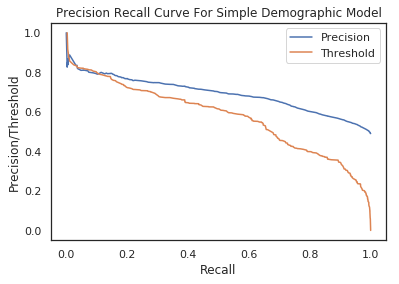

In [290]:
plt.figure()
plt.title('Precision Recall Curve For Simple Demographic Model')
sns.lineplot(baseline_recall, baseline_precision, label='Precision')
sns.lineplot(baseline_recall[:len(baseline_thresholds)], baseline_thresholds, label='Threshold')
plt.ylabel('Precision/Threshold')
plt.xlabel('Recall')
plt.legend()
plt.show()

In [291]:
best_f1_baseline_threshold = baseline_thresholds[np.argsort(-baseline_f1)[0]]

In [292]:
completion_df['send_offer'] = np.where(completion_df['view_and_complete_probability'] >= best_f1_baseline_threshold, 1, 0)
baseline_test_df['prediction'] = np.where(baseline_test_df['view_and_complete_probability'] >= best_f1_baseline_threshold, 1, 0)
roc_baseline = np.where(baseline_test_df['view_and_complete_probability'] >= best_f1_baseline_threshold, 1, 0)

In [293]:
baseline_y_preds = baseline_test_df['prediction'].values
baseline_y_test = baseline_test_df['ideal_to_send'].values

In [294]:
print('Accuracy Score on Test Set: ', np.round(accuracy_score(baseline_y_test, baseline_y_preds),2))
print('Precision Score on Test Set: ', np.round(precision_score(baseline_y_test, baseline_y_preds),2))
print('Recall Score on Test Set: ', np.round(recall_score(baseline_y_test, baseline_y_preds),2))
print('F1 Score on Test Set', np.round(f1_score(baseline_y_test, baseline_y_preds),2))

Accuracy Score on Test Set:  0.61
Precision Score on Test Set:  0.57
Recall Score on Test Set:  0.89
F1 Score on Test Set 0.69


# Creating A Better Model

Once the user has stayed longer in the platform, and performed more transactions, we can use a better model to predict whether he/she will view and complete a particular offer. 

Additional features that will be used: 

1. Tenure
2. Amount Spent Before Receiving Offer -> Normalized to a time length for every user, in this case, the time considered is from the start of experiment (time=0) until the `received_time` of each offer

In [252]:
features = ['age', 'income', 'tenure', 'M', 'F',
            'before_received_amount', 'reward', 
            'duration', 'difficulty', 'is_web',
           'is_mobile', 'is_social']

target_var = ['ideal_to_send']

In [253]:
X_train = train_df[features].fillna(0)
X_test = test_df[features].fillna(0)

y_train = train_df[target_var]
y_test = test_df[target_var]

In [254]:
param_grid = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [3, 5, 10, None],
    'min_samples_split' : [10, 50 , 100],
    'min_samples_leaf' : [10, 50, 100],
    'class_weight' : [{1:i/10, 0:1-i/10} for i in range(0, 12, 2)]
    
}

In [255]:
model = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), 
                              param_grid=param_grid, cv=3, scoring='f1')

model.fit(X_train, y_train);

In [256]:
y_scores = model.predict_proba(X_test)[:, 1:]

In [257]:
roc = model.predict(X_test)

In [258]:
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

In [259]:
f1 = 2 * (precision * recall) / (precision + recall)

In [260]:
best_f1_threshold = thresholds[np.argsort(-f1)[0]]

In [261]:
y_preds = np.where(y_scores >= best_f1_threshold, 1, 0)

In [262]:
print('Accuracy Score on Test Set: ', np.round(accuracy_score(y_test, y_preds), 2))
print('Precision Score on Test Set: ', np.round(precision_score(y_test, y_preds), 2))
print('Recall Score on Test Set: ', np.round(recall_score(y_test, y_preds), 2))
print('F1 Score on Test Set', np.round(f1_score(y_test, y_preds), 2))

Accuracy Score on Test Set:  0.69
Precision Score on Test Set:  0.65
Recall Score on Test Set:  0.83
F1 Score on Test Set 0.73


# Uplift from Baseline Model

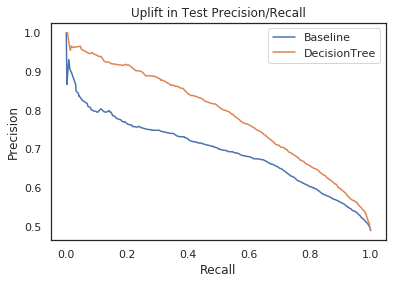

In [269]:
plt.figure()
plt.title('Uplift in Test Precision/Recall')
sns.lineplot(baseline_recall, baseline_precision, label='Baseline')
sns.lineplot(recall, precision, label='DecisionTree')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend()
plt.show()

# Understanding Who Should be Targeted For Each Offer

In [270]:
offer_demographic_df = test_df.groupby(['offer_type', 'income_group', 'age_group', 'tenure_group','M']).agg({
    'received_time' : 'count',
    'is_viewed' : 'mean',
    'is_completed' : 'mean',
    'ideal_to_send' : 'mean'
}).reset_index()


offer_demographic_df = offer_demographic_df[offer_demographic_df['received_time'] > 20]

In [271]:
display(offer_demographic_df.sort_values(by=['offer_type','ideal_to_send'], ascending=[True, False])\
    .groupby(['offer_type']).head(3))

,offer_type,income_group,age_group,tenure_group,M,received_time,is_viewed,is_completed,ideal_to_send
116,bogo,90000.0,40.0,3.0,0,37,0.972973,0.972973,0.945946
114,bogo,90000.0,40.0,2.0,0,29,0.931034,0.931034,0.862069
69,bogo,60000.0,40.0,2.0,0,58,0.931034,0.896552,0.844828
286,discount,90000.0,40.0,2.0,0,28,0.928571,0.928571,0.857143
244,discount,60000.0,40.0,3.0,0,62,0.854839,0.919355,0.822581
287,discount,90000.0,40.0,2.0,1,28,0.892857,0.928571,0.821429
437,informational,60000.0,80.0,2.0,1,23,0.869565,0.913043,0.782609
425,informational,60000.0,60.0,2.0,1,55,0.836364,0.836364,0.727273
429,informational,60000.0,60.0,4.0,1,27,0.777778,0.851852,0.703704


In [272]:
display(offer_demographic_df.sort_values(by=['offer_type','ideal_to_send'], ascending=[True, True])\
    .groupby(['offer_type']).head(3))

,offer_type,income_group,age_group,tenure_group,M,received_time,is_viewed,is_completed,ideal_to_send
38,bogo,30000.0,80.0,1.0,1,45,0.800000,0.200000,0.111111
3,bogo,30000.0,20.0,1.0,1,74,0.797297,0.243243,0.189189
27,bogo,30000.0,60.0,1.0,1,145,0.765517,0.234483,0.193103
214,discount,30000.0,80.0,1.0,1,48,0.645833,0.208333,0.187500
229,discount,60000.0,20.0,1.0,1,135,0.644444,0.355556,0.281481
191,discount,30000.0,40.0,1.0,1,149,0.536913,0.355705,0.281879
467,informational,90000.0,60.0,1.0,0,90,0.644444,0.377778,0.222222
499,informational,120000.0,60.0,1.0,0,27,0.592593,0.444444,0.222222
480,informational,90000.0,80.0,1.0,1,29,0.689655,0.413793,0.275862


In [273]:
test_df['completed_not_viewed'] = np.where((test_df['is_viewed'] == 0) & (test_df['is_completed'] == 1), 1, 0)

completed_not_viewed = test_df.groupby(['income_group', 'age_group', 'tenure_group','M']).agg({
    'received_time' : 'count',
    'completed_not_viewed' : 'mean'
}).reset_index()

In [274]:
completed_not_viewed = completed_not_viewed[completed_not_viewed['received_time'] > 20]

completed_not_viewed.sort_values(by='completed_not_viewed', ascending=False).head(5)

,income_group,age_group,tenure_group,M,received_time,completed_not_viewed
170,120000.0,60.0,3.0,1,52,0.365385
176,120000.0,80.0,3.0,0,32,0.343750
39,30000.0,80.0,2.0,0,37,0.324324
41,30000.0,80.0,3.0,0,22,0.318182
40,30000.0,80.0,2.0,1,21,0.285714
